In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.feature import StringIndexer
import datetime

spark = (
    SparkSession.builder
    .appName("Favorita_TimeSeries_Features")
    .getOrCreate()
)

spark


25/11/26 13:49:19 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
# EDIT THESE PATHS BEFORE RUNNING
input_path = "gs://aswitha-ml-data-001/train_2017_clean_ms.parquet"

output_base = "gs://aswitha-ml-data-001/ts_features"
full_output  = f"{output_base}/full"
train_output = f"{output_base}/train"
test_output  = f"{output_base}/test"

input_path, output_base


('gs://aswitha-ml-data-001/train_2017_clean_ms.parquet',
 'gs://aswitha-ml-data-001/ts_features')

In [3]:
df = spark.read.parquet(input_path)
print("Input rows:", df.count())
df.printSchema()


Input rows: 23808261
root
 |-- id: long (nullable = true)
 |-- date: timestamp_ntz (nullable = true)
 |-- store_nbr: long (nullable = true)
 |-- item_nbr: long (nullable = true)
 |-- unit_sales: double (nullable = true)
 |-- onpromotion: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- type: string (nullable = true)
 |-- cluster: long (nullable = true)
 |-- family: string (nullable = true)
 |-- class: long (nullable = true)
 |-- perishable: long (nullable = true)
 |-- transactions: long (nullable = true)
 |-- dcoilwtico: double (nullable = true)
 |-- is_holiday: long (nullable = true)
 |-- is_event: long (nullable = true)
 |-- is_work_day: long (nullable = true)
 |-- unit_sales_raw: double (nullable = true)
 |-- log_sales: double (nullable = true)



In [4]:
print("=" * 80)
print("MISSING VALUES ANALYSIS")
print("=" * 80)

# Total number of rows
total_rows = df.count()

# Compute missing values for each column
missing_df = (
    df.select([
        F.sum(F.col(c).isNull().cast("int")).alias("missing_" + c)
        for c in df.columns
    ])
)

# Convert Spark row to Python dict
missing_dict = missing_df.collect()[0].asDict()

# Convert to a list of tuples: (column_name, missing_count, percentage)
missing_table = []
for col in df.columns:
    miss_count = missing_dict["missing_" + col]
    miss_percent = (miss_count / total_rows) * 100
    if miss_count > 0:  # only include columns with missing values
        missing_table.append((col, miss_count, miss_percent))

# Display results like pandas
if missing_table:
    print(f"{'Column':30} {'Missing Count':15} {'Percentage %':15}")
    print("-" * 70)
    for col, cnt, pct in sorted(missing_table, key=lambda x: x[1], reverse=True):
        print(f"{col:30} {cnt:<15} {pct:>10.2f}")
else:
    print("✓ No missing values found in the dataset!")

MISSING VALUES ANALYSIS


✓ No missing values found in the dataset!


In [5]:
print("=" * 80)
print("DUPLICATE ANALYSIS")
print("=" * 80)

# Total rows
total_rows = df.count()

# Remove duplicates (Spark)
df_nodup = df.dropDuplicates()

# Rows after removing duplicates
rows_after = df_nodup.count()

# Number of duplicate rows
duplicates = total_rows - rows_after

print(f"Total duplicate rows: {duplicates:,}")

if duplicates > 0:
    pct = (duplicates / total_rows) * 100
    print(f"Percentage of duplicates: {pct:.2f}%")
    df_clean = df_nodup
    print(f"Rows after removing duplicates: {rows_after:,}")
else:
    print("✓ No duplicate rows found!")
    df_clean = df  # just reuse original

DUPLICATE ANALYSIS


Total duplicate rows: 0
✓ No duplicate rows found!


In [6]:
from pyspark.sql import functions as F

print("=" * 80)
print("DATA TYPES")
print("=" * 80)

# Print dtypes like pandas
for col, dtype in df_clean.dtypes:
    print(f"{col}: {dtype}")

# ----------------------------------------------------------------------
# onpromotion column analysis
# ----------------------------------------------------------------------
print("\n" + "=" * 80)
print("ONPROMOTION COLUMN ANALYSIS")
print("=" * 80)

# 1) Data type
onpromotion_dtype = dict(df_clean.dtypes)["onpromotion"]
print(f"Data type: {onpromotion_dtype}")

# 2) Unique values
unique_vals = df_clean.select("onpromotion").distinct().collect()
unique_vals_clean = [row["onpromotion"] for row in unique_vals]
print(f"Unique values: {unique_vals_clean}")

# 3) Value counts
print("\nValue counts:")
df_clean.groupBy("onpromotion").count().show()


DATA TYPES
id: bigint
date: timestamp_ntz
store_nbr: bigint
item_nbr: bigint
unit_sales: double
onpromotion: string
city: string
state: string
type: string
cluster: bigint
family: string
class: bigint
perishable: bigint
transactions: bigint
dcoilwtico: double
is_holiday: bigint
is_event: bigint
is_work_day: bigint
unit_sales_raw: double
log_sales: double

ONPROMOTION COLUMN ANALYSIS
Data type: string


Unique values: ['True', 'False']

Value counts:


+-----------+--------+
|onpromotion|   count|
+-----------+--------+
|       True| 2749649|
|      False|21058612|
+-----------+--------+



In [7]:
df_clean = df 

In [8]:
df_clean = (
    df_clean
    .withColumn(
        "unit_sales",
        F.when(F.col("unit_sales") < 0, 0).otherwise(F.col("unit_sales"))
    )
    .withColumn(
        "unit_sales_raw",
        F.when(F.col("unit_sales_raw") < 0, 0).otherwise(F.col("unit_sales_raw"))
    )
    .withColumn(
        "transactions",
        F.when(F.col("transactions") < 0, 0).otherwise(F.col("transactions"))
    )
)


In [9]:
from pyspark.sql import functions as F
from pyspark.sql import Row

print("=" * 80)
print("OUTLIER DETECTION (Using IQR Method - Pure PySpark)")
print("=" * 80)

# 1. Identify numeric columns in df_clean
numeric_types = ("int", "bigint", "double", "float", "decimal", "smallint", "tinyint")
numerical_cols = [name for name, dtype in df_clean.dtypes if any(t in dtype for t in numeric_types)]

print("Numeric columns being analyzed:", numerical_cols)

total_rows = df_clean.count()
outlier_rows = []

# 2. Loop over numeric columns
for col in numerical_cols:
    # Get Q1 and Q3 using approxQuantile (fast & scalable)
    q1, q3 = df_clean.approxQuantile(col, [0.25, 0.75], 0.01)
    IQR = q3 - q1
    lower_bound = q1 - 1.5 * IQR
    upper_bound = q3 + 1.5 * IQR

    # Count outliers using Spark
    outlier_count = df_clean.filter(
        (F.col(col) < lower_bound) | (F.col(col) > upper_bound)
    ).count()

    outlier_pct = (outlier_count / total_rows) * 100 if total_rows > 0 else 0.0

    if outlier_count > 0:
        outlier_rows.append(
            Row(
                Column=col,
                Outlier_Count=outlier_count,
                Percentage=outlier_pct,
                Lower_Bound=lower_bound,
                Upper_Bound=upper_bound,
            )
        )

# 3. Create a Spark DataFrame from the summary & display
if outlier_rows:
    outlier_df_spark = spark.createDataFrame(outlier_rows)

    # Sort by Outlier_Count descending
    outlier_df_spark = outlier_df_spark.orderBy(F.col("Outlier_Count").desc())

    print("\nOutlier summary (pure Spark):")
    outlier_df_spark.show(truncate=False)
else:
    print("✓ No outliers detected using IQR method!")


OUTLIER DETECTION (Using IQR Method - Pure PySpark)
Numeric columns being analyzed: ['id', 'store_nbr', 'item_nbr', 'unit_sales', 'cluster', 'class', 'perishable', 'transactions', 'dcoilwtico', 'is_holiday', 'is_event', 'is_work_day', 'unit_sales_raw', 'log_sales']



Outlier summary (pure Spark):


+--------------+-------------+-----------------+-------------------+------------------+
|Column        |Outlier_Count|Percentage       |Lower_Bound        |Upper_Bound       |
+--------------+-------------+-----------------+-------------------+------------------+
|unit_sales    |2315382      |9.725120200925216|-7.0               |17.0              |
|unit_sales_raw|2315382      |9.725120200925216|-7.0               |17.0              |
|is_holiday    |2259109      |9.488761064909362|0.0                |0.0               |
|transactions  |1214134      |5.099633274349605|-530.5             |3937.5            |
|class         |761145       |3.196978561348937|-1417.0            |5183.0            |
|log_sales     |509628       |2.140551130550862|-0.5493061443340548|3.8451430103383837|
+--------------+-------------+-----------------+-------------------+------------------+




[Stage 98:================================================>         (5 + 1) / 6]



## 2. Data Preprocessing

In this section, we'll:
- Handle categorical variables
- Normalize/standardize numerical features
- Handle date features
- Create train-test splits if needed
- Address data imbalances

In [10]:
print("=" * 80)
print("CATEGORICAL VARIABLES")
print("=" * 80)

# Treat string columns as categorical (similar to 'object'/'category' in pandas)
categorical_cols = [name for name, dtype in df_clean.dtypes if dtype == "string"]

print("Categorical columns:", categorical_cols)

for col in categorical_cols:
    print(f"\n{col}:")

    # Number of unique values
    unique_count = df_clean.select(col).distinct().count()
    print(f"  Unique values: {unique_count}")

    # Full value counts if <= 20 unique values
    if unique_count <= 20:
        print("  Value counts:")
        (
            df_clean.groupBy(col)
            .count()
            .orderBy(F.col("count").desc())
            .show(truncate=False)
        )
    else:
        print("  Top 10 values:")
        (
            df_clean.groupBy(col)
            .count()
            .orderBy(F.col("count").desc())
            .limit(10)
            .show(truncate=False)
        )

CATEGORICAL VARIABLES
Categorical columns: ['onpromotion', 'city', 'state', 'type', 'family']

onpromotion:


  Unique values: 2
  Value counts:


+-----------+--------+
|onpromotion|count   |
+-----------+--------+
|False      |21058612|
|True       |2749649 |
+-----------+--------+


city:


  Unique values: 22
  Top 10 values:


+-------------+-------+
|city         |count  |
+-------------+-------+
|Quito        |9528118|
|Guayaquil    |3138204|
|Cuenca       |1451431|
|Santo Domingo|1187449|
|Ambato       |977683 |
|Machala      |846001 |
|Manta        |742437 |
|Latacunga    |649127 |
|Loja         |477176 |
|Daule        |471973 |
+-------------+-------+


state:


  Unique values: 16
  Value counts:


+------------------------------+-------+
|state                         |count  |
+------------------------------+-------+
|Pichincha                     |9993056|
|Guayas                        |4271193|
|Azuay                         |1451431|
|Santo Domingo de los Tsachilas|1187449|
|Manabi                        |1039867|
|Tungurahua                    |977683 |
|El Oro                        |846001 |
|Los Rios                      |764104 |
|Cotopaxi                      |649127 |
|Loja                          |477176 |
|Esmeraldas                    |415335 |
|Santa Elena                   |389517 |
|Imbabura                      |349954 |
|Bolivar                       |339081 |
|Pastaza                       |330404 |
|Chimborazo                    |326883 |
+------------------------------+-------+


type:


  Unique values: 5
  Value counts:


+----+-------+
|type|count  |
+----+-------+
|D   |8624493|
|A   |5074823|
|C   |4807953|
|B   |3603985|
|E   |1697007|
+----+-------+


family:


  Unique values: 33
  Top 10 values:


+-------------+-------+
|family       |count  |
+-------------+-------+
|GROCERY I    |8248173|
|BEVERAGES    |3835180|
|CLEANING     |2779942|
|PRODUCE      |1793641|
|DAIRY        |1730276|
|PERSONAL CARE|857763 |
|BREAD/BAKERY |823225 |
|HOME CARE    |725955 |
|DELI         |673387 |
|MEATS        |367009 |
+-------------+-------+




[Stage 141:===================>                                     (2 + 4) / 6]



In [11]:
# Encode categorical variables

df_encoded = df_clean

categorical_cols = ["city", "state", "type", "family"]

print("=" * 80)
print("LABEL ENCODING CATEGORICAL VARIABLES (StringIndexer)")
print("=" * 80)

for col in categorical_cols:
    if col in df_encoded.columns:
        indexer = StringIndexer(
            inputCol=col,
            outputCol=f"{col}_encoded",
            handleInvalid="keep"  # ensures Spark won't crash on unseen values
        )
        model = indexer.fit(df_encoded)
        df_encoded = model.transform(df_encoded)

        print(f"✓ Encoded '{col}' — unique categories: {len(model.labels)}")

print("\nEncoded columns created successfully!")


LABEL ENCODING CATEGORICAL VARIABLES (StringIndexer)


✓ Encoded 'city' — unique categories: 22


✓ Encoded 'state' — unique categories: 16


✓ Encoded 'type' — unique categories: 5


✓ Encoded 'family' — unique categories: 33

Encoded columns created successfully!


In [12]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler
from pyspark.sql import functions as F
from pyspark.ml.functions import vector_to_array

cols_to_scale = ["unit_sales", "transactions", "dcoilwtico"]

# Assemble
assembler = VectorAssembler(
    inputCols=cols_to_scale,
    outputCol="features_raw"
)

df_scaled = assembler.transform(df_encoded)

# Standard scaler
standard_scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features_standard",
    withMean=True,
    withStd=True
)

standard_model = standard_scaler.fit(df_scaled)
df_scaled = standard_model.transform(df_scaled)

# MinMax scaler
minmax_scaler = MinMaxScaler(
    inputCol="features_raw",
    outputCol="features_minmax"
)

minmax_model = minmax_scaler.fit(df_scaled)
df_scaled = minmax_model.transform(df_scaled)

# Convert vectors to arrays
df_scaled = df_scaled.withColumn("features_standard_array", vector_to_array("features_standard"))
df_scaled = df_scaled.withColumn("features_minmax_array", vector_to_array("features_minmax"))

# Extract standard scaled values
df_scaled = df_scaled.withColumn("unit_sales_scaled", F.col("features_standard_array")[0])
df_scaled = df_scaled.withColumn("transactions_scaled", F.col("features_standard_array")[1])
df_scaled = df_scaled.withColumn("dcoilwtico_scaled", F.col("features_standard_array")[2])

# Extract min-max scaled values
df_scaled = df_scaled.withColumn("unit_sales_minmax", F.col("features_minmax_array")[0])
df_scaled = df_scaled.withColumn("transactions_minmax", F.col("features_minmax_array")[1])
df_scaled = df_scaled.withColumn("dcoilwtico_minmax", F.col("features_minmax_array")[2])

print("✓ Created standardized features (Z-score)")
print("✓ Created min-max normalized features (0–1)")

✓ Created standardized features (Z-score)
✓ Created min-max normalized features (0–1)


In [13]:
print("=" * 80)
print("REMOVING log_sales COLUMN IF PRESENT")
print("=" * 80)

if "log_sales" in df_scaled.columns:
    df_scaled = df_scaled.drop("log_sales")
    print("✓ Removed 'log_sales' feature")
    print(f"Updated column count: {len(df_scaled.columns)}")
else:
    print("'log_sales' column not found")


REMOVING log_sales COLUMN IF PRESENT
✓ Removed 'log_sales' feature
Updated column count: 34


## 3. Exploratory Data Analysis (EDA)
In this section, we'll:

- Analyze statistical summaries
- Visualize distributions
- Explore correlations
- Analyze temporal patterns
- Examine categorical relationships

Unit Sales Statistics (full data):
  Mean   : 8.16
  Median : 4.00
  Std Dev: 23.97
  Min    : 0.00
  Max    : 17146.00


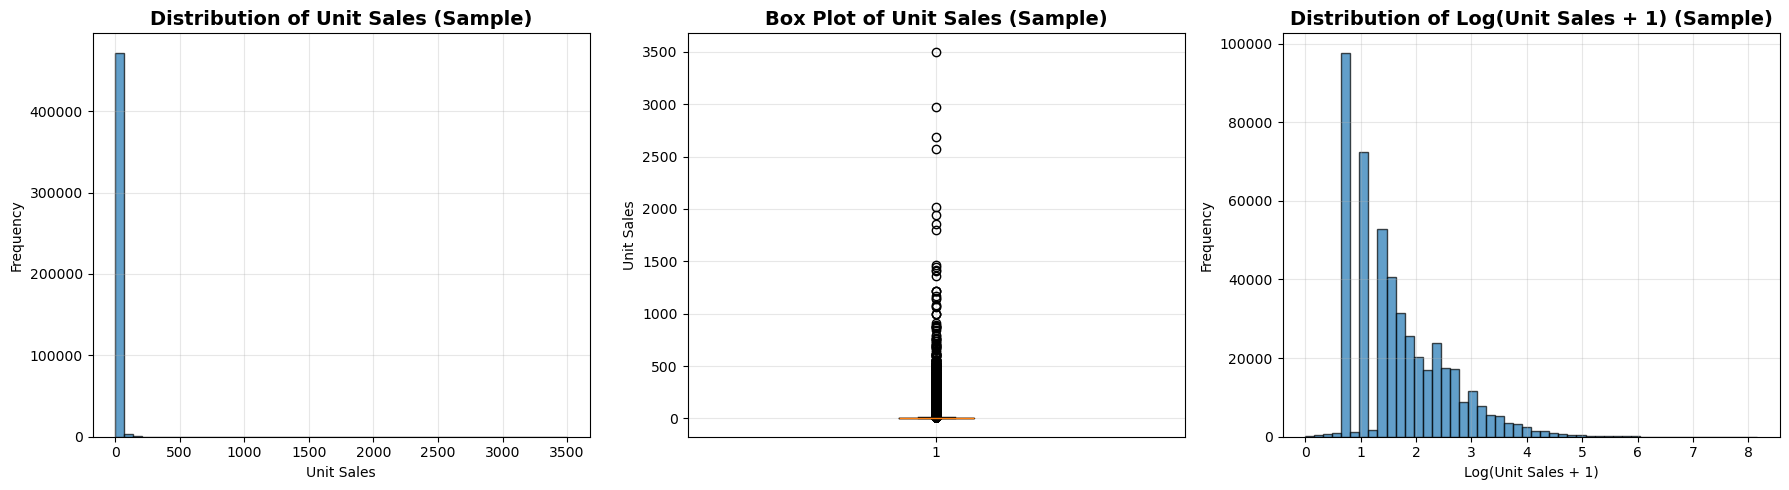

In [14]:

# ============================================================
# 1. Compute statistics in Spark (on all 23M rows)
# ============================================================
stats_row = (
    df_scaled
    .agg(
        F.mean("unit_sales").alias("mean"),
        F.expr("percentile_approx(unit_sales, 0.5, 10000)").alias("median"),
        F.stddev("unit_sales").alias("stddev"),
        F.min("unit_sales").alias("min"),
        F.max("unit_sales").alias("max")
    )
    .collect()[0]
)

print("Unit Sales Statistics (full data):")
print(f"  Mean   : {stats_row['mean']:.2f}")
print(f"  Median : {stats_row['median']:.2f}")
print(f"  Std Dev: {stats_row['stddev']:.2f}")
print(f"  Min    : {stats_row['min']:.2f}")
print(f"  Max    : {stats_row['max']:.2f}")

# ============================================================
# 2. Take a manageable sample for plotting
#    (DON'T bring all 23M rows to the driver)
# ============================================================
# Choose a small fraction – tune this if needed
sample_fraction = 0.02  # 2% of 23M ≈ 460k rows

pdf = (
    df_scaled
    .select("unit_sales")
    .sample(withReplacement=False, fraction=sample_fraction, seed=42)
    .toPandas()
)

# Optional: if even this feels heavy, you can cap size:
# pdf = pdf.sample(n=200_000, random_state=42)  # downsample on pandas side

# ============================================================
# 3. Plot using matplotlib (same logic as your original code)
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(pdf['unit_sales'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Unit Sales (Sample)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Unit Sales')
axes[0].set_ylabel('Frequency')
axes[0].grid(alpha=0.3)

# Box plot
axes[1].boxplot(pdf['unit_sales'], vert=True)
axes[1].set_title('Box Plot of Unit Sales (Sample)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Unit Sales')
axes[1].grid(alpha=0.3)

# Log-transformed histogram
axes[2].hist(np.log1p(pdf['unit_sales']), bins=50, edgecolor='black', alpha=0.7)
axes[2].set_title('Distribution of Log(Unit Sales + 1) (Sample)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Log(Unit Sales + 1)')
axes[2].set_ylabel('Frequency')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


CORRELATION ANALYSIS (PySpark Optimized)
-> Using a 100.0% sample for correlation computation



[Stage 166:===============================================>         (5 + 1) / 6]



Row count used for correlation: 23808261


25/11/26 13:56:10 WARN PearsonCorrelation: Pearson correlation matrix contains NaN values.


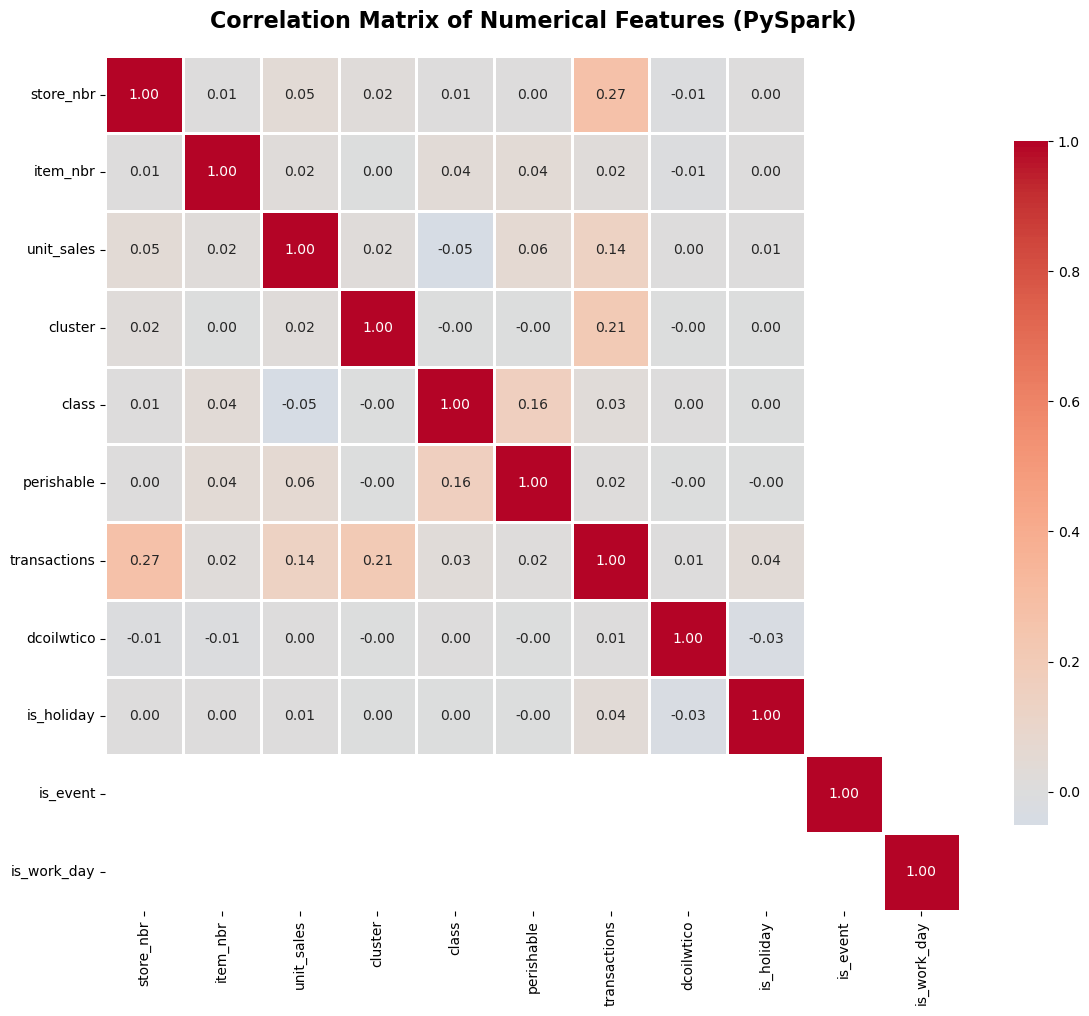


Correlations with Unit Sales (sorted by absolute value):
unit_sales      1.000000
transactions    0.135468
perishable      0.060417
class          -0.051438
store_nbr       0.045117
item_nbr        0.023928
cluster         0.021973
is_holiday      0.007772
dcoilwtico      0.003242
is_event             NaN
is_work_day          NaN
Name: unit_sales, dtype: float64


In [15]:
# ==============================================================
# CORRELATION ANALYSIS (PySpark + Spark ML, Optimized Version)
# ==============================================================

from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 80)
print("CORRELATION ANALYSIS (PySpark Optimized)")
print("=" * 80)

# ----------------------------------------------------------------
# 1. CONFIG
# ----------------------------------------------------------------
# Use the same numerical features as in your pandas code
numerical_features = [
    'store_nbr', 'item_nbr', 'unit_sales', 'cluster', 'class',
    'perishable', 'transactions', 'dcoilwtico', 'is_holiday',
    'is_event', 'is_work_day'
]

# Optional: sample fraction for super large datasets
# Set to 1.0 to use full data
USE_SAMPLING = True
SAMPLE_FRACTION = 1.0  # 10% sample
SAMPLE_SEED = 42

# ----------------------------------------------------------------
# 2. SELECT NUMERICAL COLUMNS (AND SAMPLE IF NEEDED)
# ----------------------------------------------------------------
# Assumes df_encoded already exists as a Spark DataFrame
df_corr = df_scaled.select(numerical_features)

if USE_SAMPLING:
    print(f"-> Using a {SAMPLE_FRACTION*100:.1f}% sample for correlation computation")
    df_corr = df_corr.sample(withReplacement=False,
                             fraction=SAMPLE_FRACTION,
                             seed=SAMPLE_SEED)

print("Row count used for correlation:", df_corr.count())

# ----------------------------------------------------------------
# 3. BUILD FEATURE VECTOR & COMPUTE CORRELATION MATRIX (SPARK-ML)
# ----------------------------------------------------------------
assembler = VectorAssembler(
    inputCols=numerical_features,
    outputCol="features"
)

df_vec = assembler.transform(df_corr).select("features")

# Correlation.corr returns a DenseMatrix wrapped in a Row
corr_matrix = Correlation.corr(df_vec, "features", "pearson").head()[0]
corr_array = corr_matrix.toArray()

# Convert to pandas DataFrame for plotting & inspection
corr_df = pd.DataFrame(
    corr_array,
    index=numerical_features,
    columns=numerical_features
)

# ----------------------------------------------------------------
# 4. PLOT CORRELATION HEATMAP (LIKE YOUR PANDAS VERSION)
# ----------------------------------------------------------------
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_df,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8}
)
plt.title('Correlation Matrix of Numerical Features (PySpark)', fontsize=16,
          fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------
# 5. SHOW CORRELATIONS WITH TARGET VARIABLE (unit_sales)
# ----------------------------------------------------------------
print("\nCorrelations with Unit Sales (sorted by absolute value):")

# Sort by absolute value, descending
target_corr = corr_df['unit_sales'].reindex(numerical_features)
target_corr_sorted = target_corr.reindex(
    target_corr.abs().sort_values(ascending=False).index
)

print(target_corr_sorted)


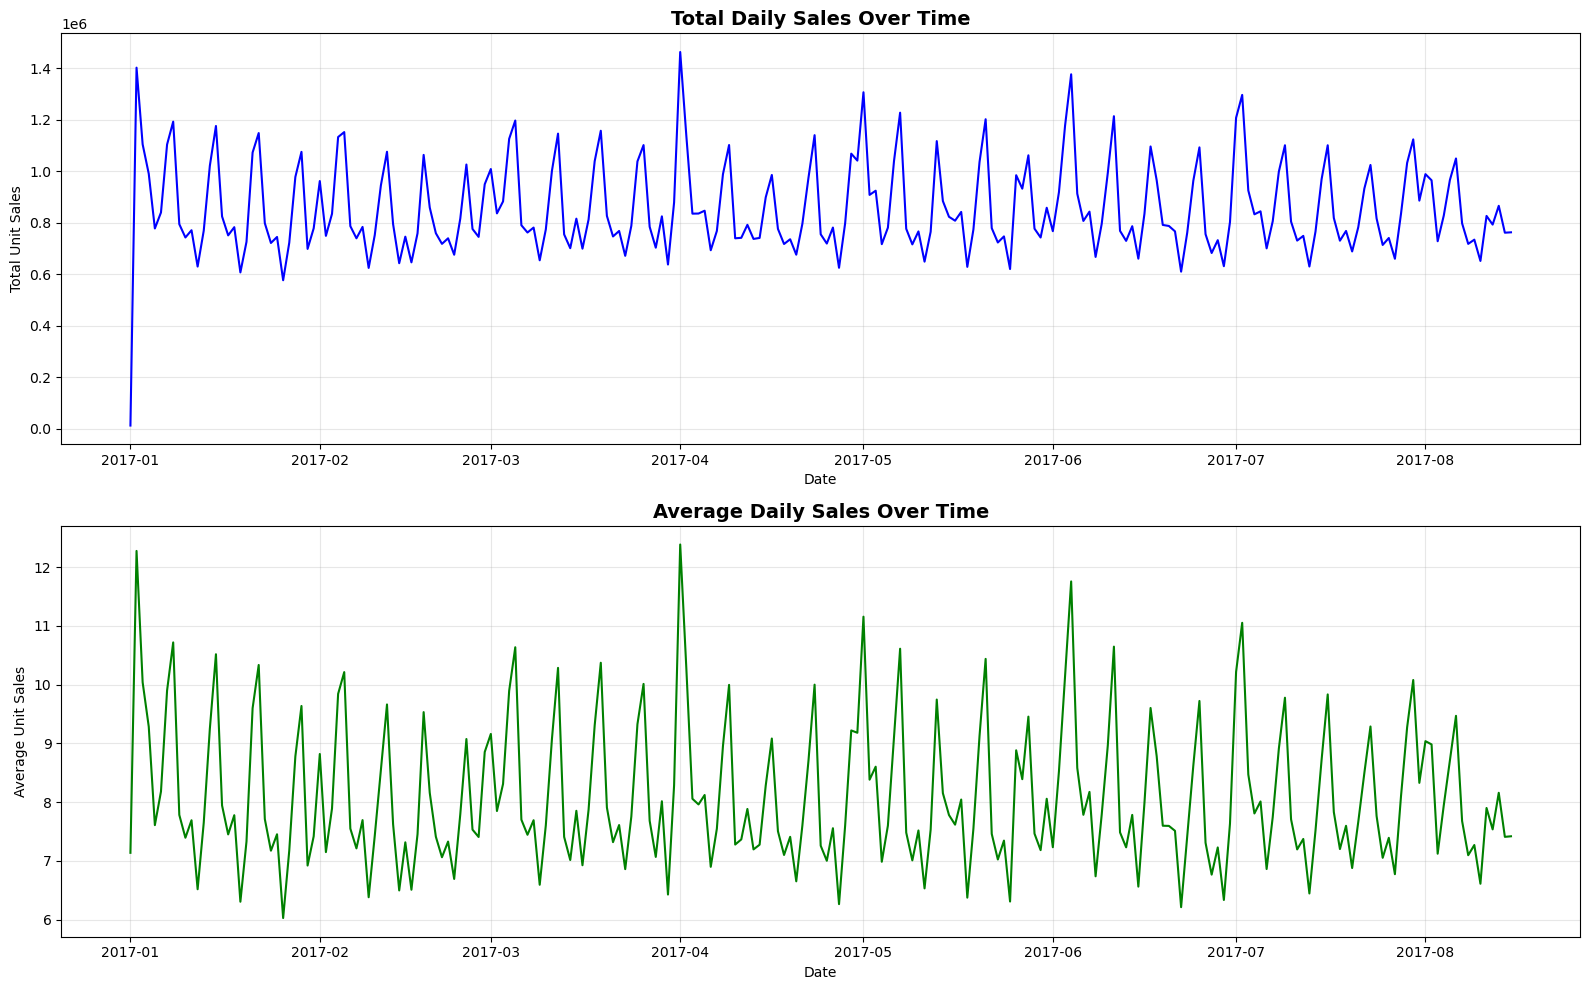

In [16]:


# ============================================================
# 1. Aggregate in Spark (fast, distributed)
# ============================================================
daily_sales_spark = (
    df_scaled
    .groupBy("date")
    .agg(
        F.sum("unit_sales").alias("total_sales"),
        F.mean("unit_sales").alias("avg_sales"),
        F.count("unit_sales").alias("count_sales")
    )
    .orderBy("date")
)

# ============================================================
# 2. Convert aggregated results to pandas 
#    (safe because rows ≈ number of days)
# ============================================================
daily_sales = daily_sales_spark.toPandas()

# ============================================================
# 3. Plot (same as your original code)
# ============================================================
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Total daily sales
axes[0].plot(daily_sales['date'], daily_sales['total_sales'], linewidth=1.5, color='blue')
axes[0].set_title('Total Daily Sales Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Total Unit Sales')
axes[0].grid(alpha=0.3)

# Average daily sales
axes[1].plot(daily_sales['date'], daily_sales['avg_sales'], linewidth=1.5, color='green')
axes[1].set_title('Average Daily Sales Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Average Unit Sales')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


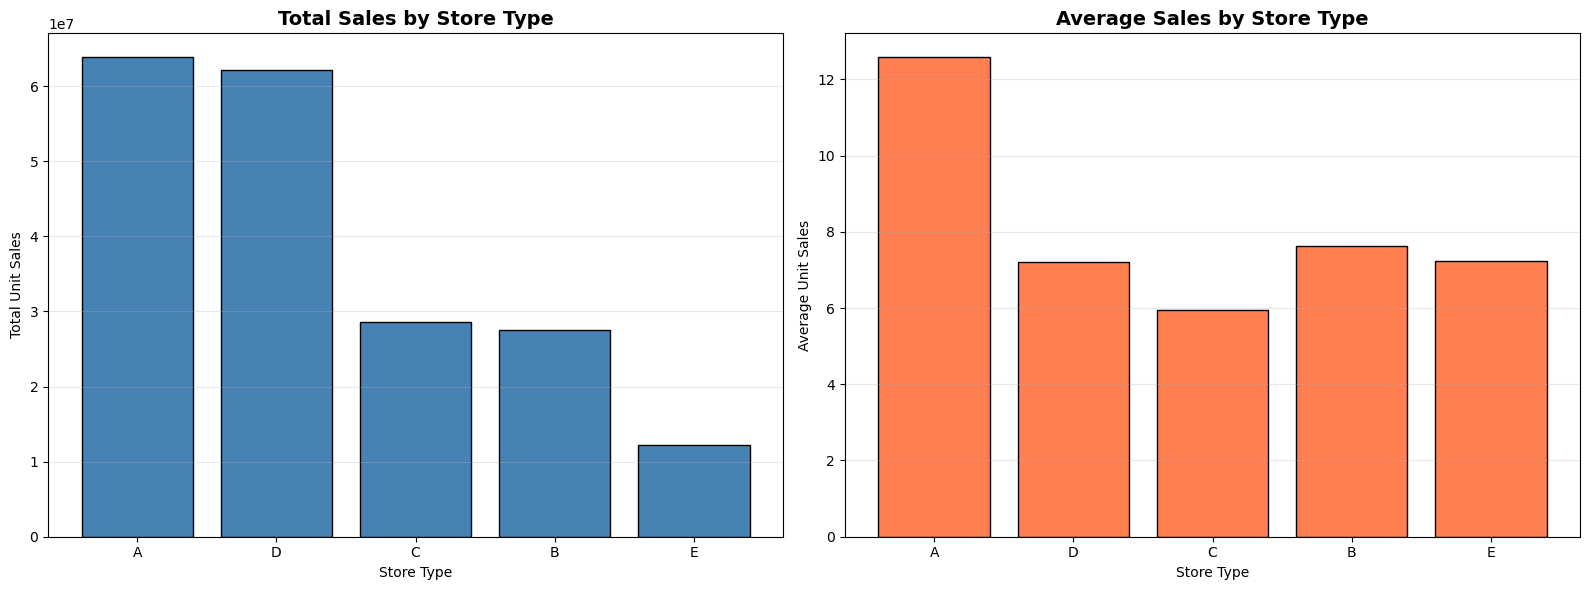


Sales by Store Type:
type  total_sales  avg_sales
   A 63830659.391  12.577909
   D 62091375.630   7.199423
   C 28552583.254   5.938615
   B 27500760.621   7.630653
   E 12267079.180   7.228656


In [17]:
## Sales by store type


# ============================================================
# 1. Aggregate in Spark (fast, distributed)
# ============================================================
store_type_sales_spark = (
    df_scaled
    .groupBy("type")
    .agg(
        F.sum("unit_sales").alias("total_sales"),
        F.mean("unit_sales").alias("avg_sales")
    )
)

# Order store types by total sales
store_type_sales_spark = store_type_sales_spark.orderBy(F.desc("total_sales"))

# ============================================================
# 2. Convert to pandas (safe: store types = ~ few categories)
# ============================================================
store_type_sales = store_type_sales_spark.toPandas()

# ============================================================
# 3. Plot with matplotlib (same as your original logic)
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Total Sales by Store Type
axes[0].bar(
    store_type_sales["type"], 
    store_type_sales["total_sales"],
    color="steelblue", edgecolor="black"
)
axes[0].set_title("Total Sales by Store Type", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Store Type")
axes[0].set_ylabel("Total Unit Sales")
axes[0].grid(alpha=0.3, axis="y")

# Average Sales by Store Type
axes[1].bar(
    store_type_sales["type"], 
    store_type_sales["avg_sales"],
    color="coral", edgecolor="black"
)
axes[1].set_title("Average Sales by Store Type", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Store Type")
axes[1].set_ylabel("Average Unit Sales")
axes[1].grid(alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

# ============================================================
# 4. Print table result
# ============================================================
print("\nSales by Store Type:")
print(store_type_sales.to_string(index=False))


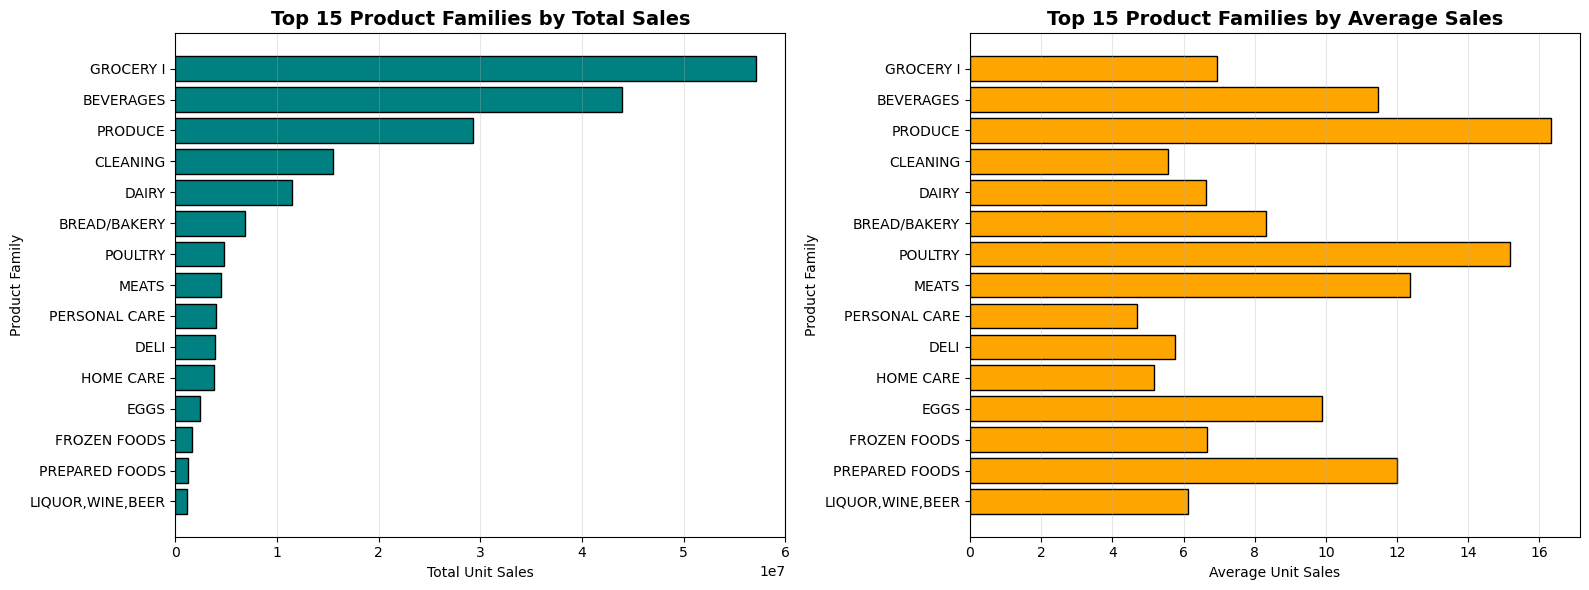

In [18]:

# Sales by product family (top 15)


# ============================================================
# 1. Aggregate in Spark (distributed)
# ============================================================
family_sales_spark = (
    df_scaled
    .groupBy("family")
    .agg(
        F.sum("unit_sales").alias("total_sales"),
        F.mean("unit_sales").alias("avg_sales"),
        F.count("unit_sales").alias("count_sales")
    )
)

# Order by total sales (descending)
family_sales_spark = family_sales_spark.orderBy(F.desc("total_sales"))

# ============================================================
# 2. Bring top 15 to pandas (safe)
# ============================================================
family_sales = family_sales_spark.limit(15).toPandas()

# Sort again in pandas for correct horizontal bar order
family_sales = family_sales.sort_values("total_sales", ascending=False)

# ============================================================
# 3. Plot (same as your matplotlib code)
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Total Sales - Horizontal bar chart
axes[0].barh(family_sales['family'], family_sales['total_sales'], 
             color='teal', edgecolor='black')
axes[0].set_title('Top 15 Product Families by Total Sales', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Total Unit Sales')
axes[0].set_ylabel('Product Family')
axes[0].invert_yaxis()
axes[0].grid(alpha=0.3, axis='x')

# Average Sales - Horizontal bar chart
axes[1].barh(family_sales['family'], family_sales['avg_sales'], 
             color='orange', edgecolor='black')
axes[1].set_title('Top 15 Product Families by Average Sales', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Average Unit Sales')
axes[1].set_ylabel('Product Family')
axes[1].invert_yaxis()
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


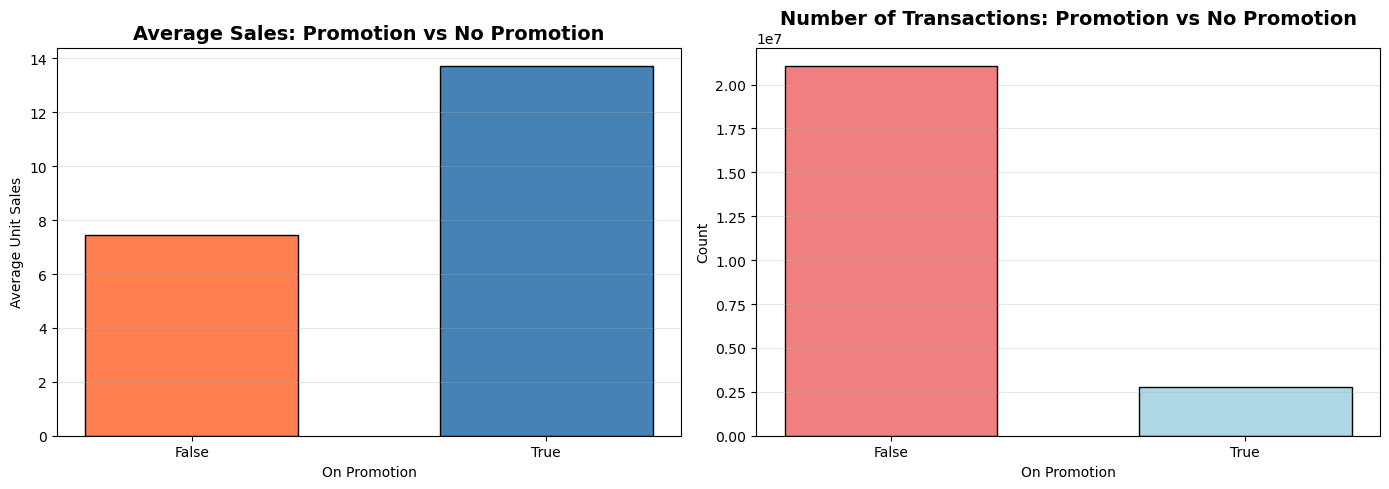


Promotion Impact:
onpromotion  total_sales  avg_sales  count_txn
      False 1.565207e+08   7.432624   21058612
       True 3.772171e+07  13.718737    2749649


In [19]:
# Promotion impact analysis

# ============================================================
# 1. Aggregate in Spark (onpromotion vs not)
# ============================================================
promotion_sales_spark = (
    df_scaled
    .groupBy("onpromotion")
    .agg(
        F.sum("unit_sales").alias("total_sales"),
        F.mean("unit_sales").alias("avg_sales"),
        F.count("*").alias("count_txn")
    )
    .orderBy("onpromotion")   # False first, then True
)

# Bring tiny result (2 rows) to pandas
promotion_sales = promotion_sales_spark.toPandas()

# ============================================================
# 2. Plot with matplotlib
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x_labels = promotion_sales["onpromotion"].astype(str)

# Average sales bar chart
axes[0].bar(
    x_labels,
    promotion_sales["avg_sales"],
    color=["coral", "steelblue"],
    edgecolor="black",
    width=0.6
)
axes[0].set_title("Average Sales: Promotion vs No Promotion", fontsize=14, fontweight="bold")
axes[0].set_xlabel("On Promotion")
axes[0].set_ylabel("Average Unit Sales")
axes[0].grid(alpha=0.3, axis="y")

# Count of transactions bar chart
axes[1].bar(
    x_labels,
    promotion_sales["count_txn"],
    color=["lightcoral", "lightblue"],
    edgecolor="black",
    width=0.6
)
axes[1].set_title("Number of Transactions: Promotion vs No Promotion", fontsize=14, fontweight="bold")
axes[1].set_xlabel("On Promotion")
axes[1].set_ylabel("Count")
axes[1].grid(alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

# ============================================================
# 3. Print table
# ============================================================
print("\nPromotion Impact:")
print(promotion_sales.to_string(index=False))

# ============================================================
# 4. Percentage increase in avg sales due to promotion
# ============================================================
if set(promotion_sales["onpromotion"]) == {True, False}:
    promo_mean = promotion_sales.loc[promotion_sales["onpromotion"] == True, "avg_sales"].iloc[0]
    no_promo_mean = promotion_sales.loc[promotion_sales["onpromotion"] == False, "avg_sales"].iloc[0]

    if no_promo_mean != 0:
        pct_increase = ((promo_mean - no_promo_mean) / no_promo_mean) * 100
        print(f"\n✓ Promotions increase average sales by {pct_increase:.2f}%")
    else:
        print("\n⚠ Cannot compute % increase: average sales without promotion is 0.")


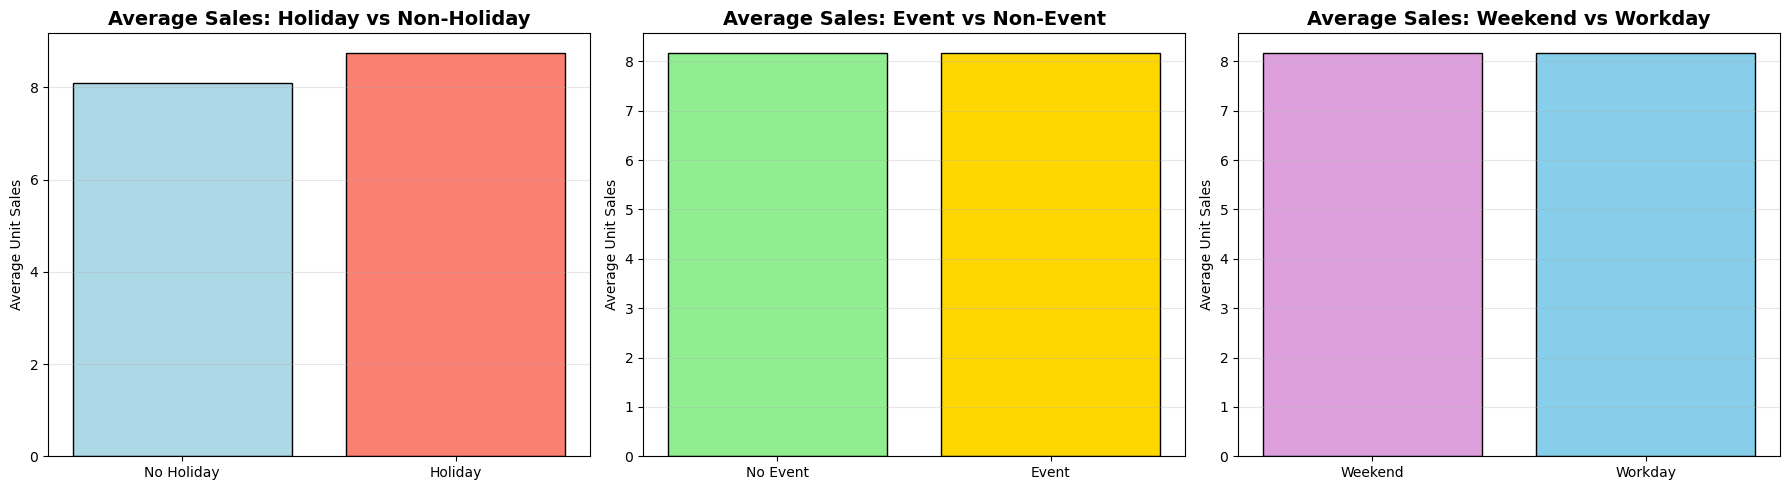

In [20]:
# Holiday and event impact

# ============================================================
# 1. Aggregate in Spark (means by flag columns)
# ============================================================

# Holiday impact
holiday_sales_spark = (
    df_scaled
    .groupBy("is_holiday")
    .agg(F.mean("unit_sales").alias("avg_sales"))
    .orderBy("is_holiday")      # False -> True
)
holiday_sales = holiday_sales_spark.toPandas()

# Event impact
event_sales_spark = (
    df_scaled
    .groupBy("is_event")
    .agg(F.mean("unit_sales").alias("avg_sales"))
    .orderBy("is_event")
)
event_sales = event_sales_spark.toPandas()

# Workday impact
workday_sales_spark = (
    df_scaled
    .groupBy("is_work_day")
    .agg(F.mean("unit_sales").alias("avg_sales"))
    .orderBy("is_work_day")
)
workday_sales = workday_sales_spark.toPandas()

# ============================================================
# 2. Plot with matplotlib (same visuals as your pandas code)
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Holiday impact
axes[0].bar(
    ['No Holiday', 'Holiday'],
    holiday_sales['avg_sales'].values,
    color=['lightblue', 'salmon'],
    edgecolor='black'
)
axes[0].set_title('Average Sales: Holiday vs Non-Holiday', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Average Unit Sales')
axes[0].grid(alpha=0.3, axis='y')

# Event impact
axes[1].bar(
    ['No Event', 'Event'],
    event_sales['avg_sales'].values,
    color=['lightgreen', 'gold'],
    edgecolor='black'
)
axes[1].set_title('Average Sales: Event vs Non-Event', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Average Unit Sales')
axes[1].grid(alpha=0.3, axis='y')

# Work day impact
axes[2].bar(
    ['Weekend', 'Workday'],
    workday_sales['avg_sales'].values,
    color=['plum', 'skyblue'],
    edgecolor='black'
)
axes[2].set_title('Average Sales: Weekend vs Workday', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Average Unit Sales')
axes[2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


Correlation between oil price and unit sales: 0.0032


Sample size used for scatterplot: 9932 rows


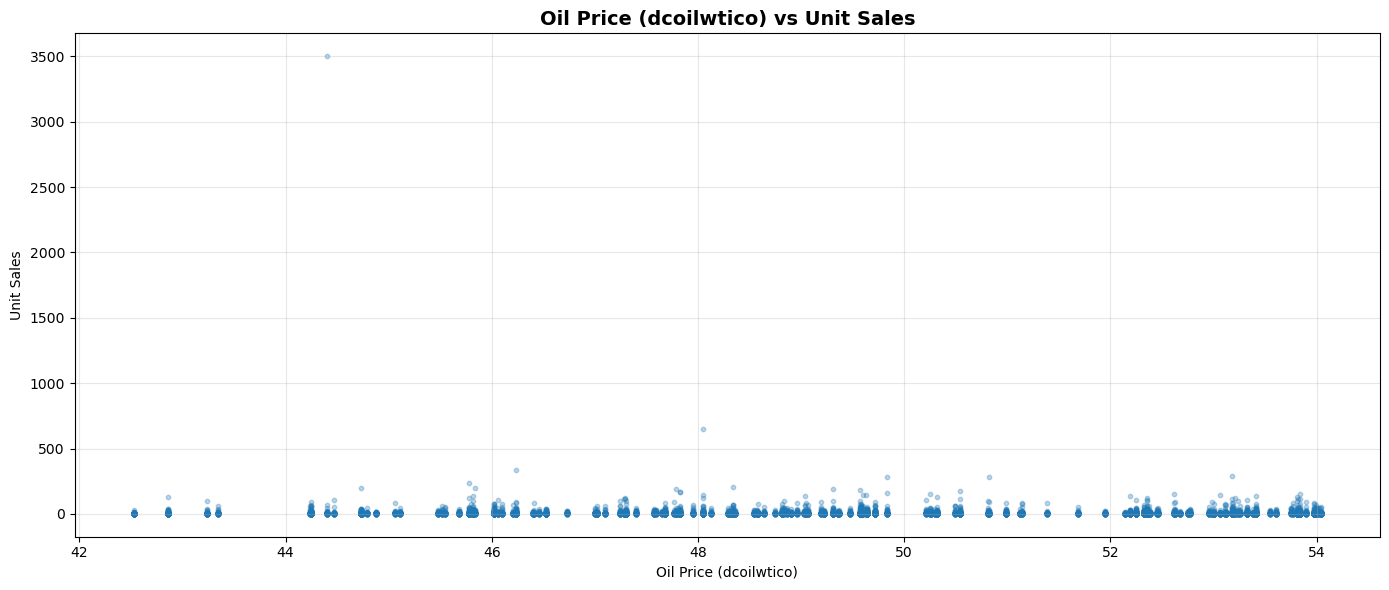

In [21]:
# Oil price vs sales relationship
# ============================================================
# 1. Compute correlation in Spark (fast)
# ============================================================
oil_sales_corr = df_scaled.stat.corr("dcoilwtico", "unit_sales")
print(f"Correlation between oil price and unit sales: {oil_sales_corr:.4f}")

# ============================================================
# 2. Take a Spark sample for plotting
# ============================================================
sample_fraction = 10_000 / df_encoded.count()

sample_df = (
    df_scaled
    .select("dcoilwtico", "unit_sales")
    .sample(False, sample_fraction, seed=42)
    .limit(10_000)      # hard cap to keep pandas safe
    .toPandas()
)

print(f"Sample size used for scatterplot: {len(sample_df)} rows")

# ============================================================
# 3. Plot in matplotlib
# ============================================================
plt.figure(figsize=(14, 6))
plt.scatter(
    sample_df["dcoilwtico"], 
    sample_df["unit_sales"], 
    alpha=0.3, s=10
)
plt.title('Oil Price (dcoilwtico) vs Unit Sales', fontsize=14, fontweight='bold')
plt.xlabel('Oil Price (dcoilwtico)')
plt.ylabel('Unit Sales')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


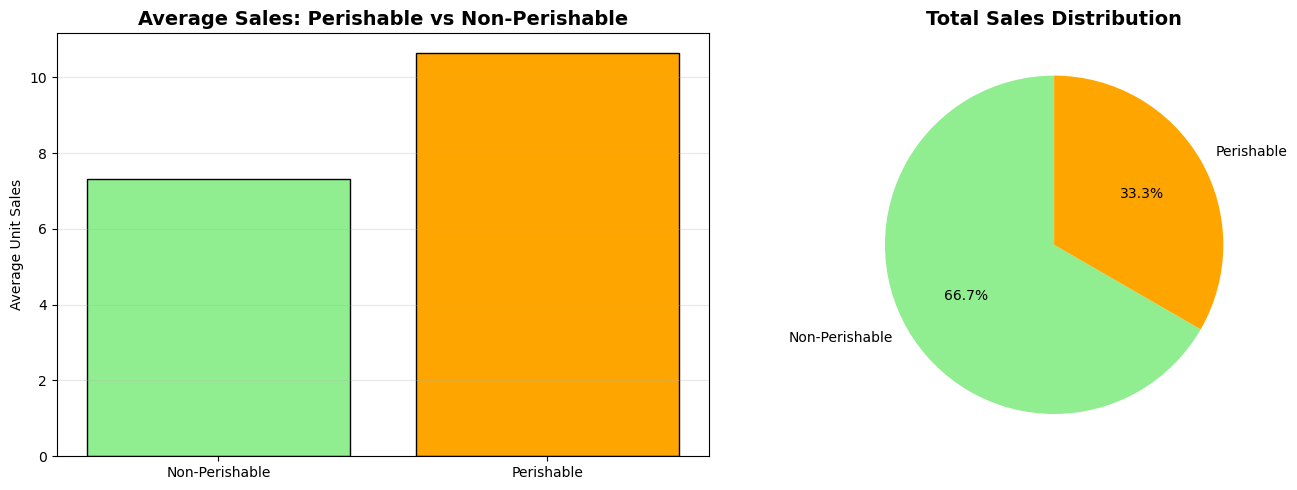


Perishable vs Non-Perishable Sales:
 perishable  total_sales  avg_sales  count_sales
          0 1.295000e+08   7.309420     17716866
          1 6.474244e+07  10.628509      6091395


In [22]:

# Perishable vs non-perishable products

# ============================================================
# 1. Aggregate in Spark
# ============================================================
perishable_sales_spark = (
    df_scaled
    .groupBy("perishable")
    .agg(
        F.sum("unit_sales").alias("total_sales"),
        F.mean("unit_sales").alias("avg_sales"),
        F.count("*").alias("count_sales")
    )
    .orderBy("perishable")          # 0 = non-perishable, 1 = perishable
)

perishable_sales = perishable_sales_spark.toPandas()

# Rename for readability
labels = ["Non-Perishable", "Perishable"]

# ============================================================
# 2. Plot with matplotlib
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Average sales comparison
axes[0].bar(
    labels,
    perishable_sales["avg_sales"].values,
    color=["lightgreen", "orange"],
    edgecolor="black"
)
axes[0].set_title("Average Sales: Perishable vs Non-Perishable", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Average Unit Sales")
axes[0].grid(alpha=0.3, axis="y")

# Pie chart of total sales distribution
axes[1].pie(
    perishable_sales["total_sales"].values,
    labels=labels,
    autopct="%1.1f%%",
    colors=["lightgreen", "orange"],
    startangle=90
)
axes[1].set_title("Total Sales Distribution", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

# ============================================================
# 3. Print the aggregated table
# ============================================================
print("\nPerishable vs Non-Perishable Sales:")
print(perishable_sales.to_string(index=False))


## 4. Time Series Feature Engineering (For 14-Day Forecasting)

**Problem Statement**: Predict sales for the next 14 days for specific store-item combinations

This section creates time series specific features:
- Lag features (previous sales)
- Rolling statistics (moving averages, std, min, max)
- Exponential weighted features
- Store-item specific temporal patterns
- Proper train-test split for time series

In [23]:
from pyspark.sql import functions as F

print("=" * 80)
print("TIME SERIES DATA PREPARATION (PySpark)")
print("=" * 80)

# In Spark, this is simply assigning a new variable (no .copy())
df_features = df_scaled

# Distributed sort (critical for time-series windows)
df_ts = df_features.orderBy(["store_nbr", "item_nbr", "date"])

print("✓ Data sorted by store_nbr, item_nbr, date")

# Dataset shape equivalent: number of rows + number of columns
row_count = df_ts.count()
col_count = len(df_ts.columns)
print(f"Dataset size: {row_count:,} rows × {col_count} columns")

# Date range
date_min = df_ts.agg(F.min("date")).collect()[0][0]
date_max = df_ts.agg(F.max("date")).collect()[0][0]
print(f"\nDate range: {date_min} to {date_max}")

# Unique stores
unique_stores = df_ts.select("store_nbr").distinct().count()
print(f"Number of unique stores: {unique_stores}")

# Unique items
unique_items = df_ts.select("item_nbr").distinct().count()
print(f"Number of unique items: {unique_items}")

# Unique store-item combinations
unique_pairs = (
    df_ts
    .select("store_nbr", "item_nbr")
    .distinct()
    .count()
)
print(f"Store-item combinations: {unique_pairs:,}")


TIME SERIES DATA PREPARATION (PySpark)
✓ Data sorted by store_nbr, item_nbr, date
Dataset size: 23,808,261 rows × 34 columns



Date range: 2017-01-01 00:00:00 to 2017-08-15 00:00:00


Number of unique stores: 54


Number of unique items: 4018


Store-item combinations: 167,515


In [24]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

print("=" * 80)
print("CREATING LAG FEATURES (PySpark Optimized)")
print("=" * 80)

lag_days = [1, 2, 3, 7, 14, 21, 28]

# Window definition: partition by store + item, ordered by date
w = (
    Window
    .partitionBy("store_nbr", "item_nbr")
    .orderBy("date")
)

# Create lag features in one pass
for lag in lag_days:
    df_ts = df_ts.withColumn(
        f"sales_lag_{lag}",
        F.lag("unit_sales", lag).over(w)
    )

print(f"✓ Created {len(lag_days)} lag features.")


CREATING LAG FEATURES (PySpark Optimized)
✓ Created 7 lag features.


In [25]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

print("=" * 80)
print("CREATING ROLLING WINDOW FEATURES (PySpark)")
print("=" * 80)

# Make sure date is proper type and DataFrame is logically ordered
df_ts = df_ts.orderBy("store_nbr", "item_nbr", "date")

rolling_windows = [7, 14, 30]

# For each window, we create a window spec that excludes the current row,
# mimicking: x.shift(1).rolling(window=win)
for win in rolling_windows:
    # Window: partition by store & item, ordered by date, previous 'win' rows, excluding current
    w = (
        Window
        .partitionBy("store_nbr", "item_nbr")
        .orderBy("date")
        .rowsBetween(-win, -1)    # "shift(1) + rolling(window=win, min_periods=1)"
    )

    df_ts = df_ts.withColumn(
        f"sales_rolling_mean_{win}",
        F.avg("unit_sales").over(w)
    )

    df_ts = df_ts.withColumn(
        f"sales_rolling_std_{win}",
        F.stddev("unit_sales").over(w)
    )

    df_ts = df_ts.withColumn(
        f"sales_rolling_min_{win}",
        F.min("unit_sales").over(w)
    )

    df_ts = df_ts.withColumn(
        f"sales_rolling_max_{win}",
        F.max("unit_sales").over(w)
    )

print("✓ Finished building rolling window features (mean/std/min/max) for 7, 14, 30 days.")


CREATING ROLLING WINDOW FEATURES (PySpark)
✓ Finished building rolling window features (mean/std/min/max) for 7, 14, 30 days.


In [26]:
from pyspark.sql.types import StructType, StructField, DoubleType

# Base schema = original df_ts
base_schema = df_ts.schema

# EWMA spans (like your pandas code)
ewma_spans = [7, 14, 30]

# Add new columns to schema
extra_fields = [
    StructField(f"sales_ewm_{span}", DoubleType(), True)
    for span in ewma_spans
]

ewm_schema = StructType(list(base_schema.fields) + extra_fields)

import pandas as pd

def add_exact_ewma(pdf: pd.DataFrame) -> pd.DataFrame:
    # Must sort like you do in pandas
    pdf = pdf.sort_values("date")

    for span in [7, 14, 30]:
        pdf[f"sales_ewm_{span}"] = (
            pdf["unit_sales"]
               .shift(1)
               .ewm(span=span, min_periods=1)
               .mean()
        )

    return pdf
print("=" * 80)
print("CREATING EXACT EWMA FEATURES (pandas-style in PySpark)")
print("=" * 80)

df_ts = (
    df_ts
        .groupBy("store_nbr", "item_nbr")
        .applyInPandas(add_exact_ewma, schema=ewm_schema)
)

print("✓ EXACT EWMA features created (same as pandas)")

CREATING EXACT EWMA FEATURES (pandas-style in PySpark)
✓ EXACT EWMA features created (same as pandas)


In [27]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

print("=" * 80)
print("CREATING DIFFERENCE + PERCENTAGE CHANGE FEATURES (PySpark)")
print("=" * 80)

# Window: per store-item, ordered by date
w = (
    Window
    .partitionBy("store_nbr", "item_nbr")
    .orderBy("date")
)

# Previous values (1-day and 7-day lags)
lag1 = F.lag("unit_sales", 1).over(w)
lag7 = F.lag("unit_sales", 7).over(w)

# Day-over-day difference
df_ts = df_ts.withColumn("sales_diff_1", F.col("unit_sales") - lag1)

# Week-over-week difference
df_ts = df_ts.withColumn("sales_diff_7", F.col("unit_sales") - lag7)

# Day-over-day percentage change
df_ts = df_ts.withColumn(
    "sales_pct_change_1",
    F.when(lag1 != 0, (F.col("unit_sales") - lag1) / lag1).otherwise(None)
)

# Week-over-week percentage change
df_ts = df_ts.withColumn(
    "sales_pct_change_7",
    F.when(lag7 != 0, (F.col("unit_sales") - lag7) / lag7).otherwise(None)
)

print("✓ Created difference features:")
print("  - sales_diff_1        (Day-over-day change)")
print("  - sales_diff_7        (Week-over-week change)")
print("  - sales_pct_change_1  (Day-over-day % change)")
print("  - sales_pct_change_7  (Week-over-week % change)")


CREATING DIFFERENCE + PERCENTAGE CHANGE FEATURES (PySpark)
✓ Created difference features:
  - sales_diff_1        (Day-over-day change)
  - sales_diff_7        (Week-over-week change)
  - sales_pct_change_1  (Day-over-day % change)
  - sales_pct_change_7  (Week-over-week % change)


In [28]:
from pyspark.sql import functions as F

print("=" * 80)
print("CREATING TEMPORAL FEATURES (PySpark)")
print("=" * 80)

# Make sure date is a proper date type
df_ts = df_ts.withColumn("date", F.to_date("date"))

# Basic calendar parts
df_ts = (
    df_ts
    .withColumn("year",         F.year("date"))
    .withColumn("month",        F.month("date"))
    .withColumn("day",          F.dayofmonth("date"))
    .withColumn("day_of_year",  F.dayofyear("date"))
    .withColumn("week_of_year", F.weekofyear("date"))
    .withColumn("quarter",      F.quarter("date"))
)

# day_of_week: pandas 0=Mon,...,6=Sun
# Spark dayofweek() → 1=Sun,...,7=Sat, so adjust:
df_ts = df_ts.withColumn("day_of_week", (F.dayofweek("date") + 5) % 7)

# weekend flag
df_ts = df_ts.withColumn(
    "is_weekend",
    F.when(F.col("day_of_week") >= 5, 1).otherwise(0)
)

# month start / end
df_ts = df_ts.withColumn(
    "is_month_start",
    F.when(F.dayofmonth("date") == 1, 1).otherwise(0)
)

df_ts = df_ts.withColumn(
    "is_month_end",
    F.when(F.dayofmonth("date") == F.dayofmonth(F.last_day("date")), 1).otherwise(0)
)



print("✓ Created temporal features:")
print("  - year, month, day, day_of_week, day_of_year")
print("  - week_of_year, quarter")
print("  - is_weekend, is_month_start, is_month_end")



CREATING TEMPORAL FEATURES (PySpark)
✓ Created temporal features:
  - year, month, day, day_of_week, day_of_year
  - week_of_year, quarter
  - is_weekend, is_month_start, is_month_end


In [29]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

print("=" * 80)
print("CREATING STORE-ITEM TEMPORAL FEATURES (PySpark - no parquet writing)")
print("=" * 80)

# Ensure df_ts has: store_nbr, item_nbr, date, day_of_week, month, unit_sales, onpromotion

# Main time window ordered by date for lag & rolling
w_time = (
    Window
    .partitionBy("store_nbr", "item_nbr")
    .orderBy("date")
)

# Rolling window: previous 30 rows, excluding current (shift(1).rolling(...))
w_roll_30 = w_time.rowsBetween(-30, -1)

# Averages by store-item-day_of_week
w_dow = Window.partitionBy("store_nbr", "item_nbr", "day_of_week")

# Averages by store-item-month
w_month = Window.partitionBy("store_nbr", "item_nbr", "month")

# Create features
df_ts = (
    df_ts
    # store-item average sales per day of week
    .withColumn(
        "store_item_dow_avg_sales",
        F.avg("unit_sales").over(w_dow)
    )
    # store-item average sales per month
    .withColumn(
        "store_item_month_avg_sales",
        F.avg("unit_sales").over(w_month)
    )
    # promo lag features
    .withColumn(
        "promo_lag_7",
        F.lag("onpromotion", 7).over(w_time).cast("double")
    )
    .withColumn(
        "promo_lag_14",
        F.lag("onpromotion", 14).over(w_time).cast("double")
    )
    # rolling promo mean (last 30)
    .withColumn(
        "promo_rolling_30",
        F.avg("onpromotion").over(w_roll_30)
    )
)

print("✓ Temporal features created successfully!")


CREATING STORE-ITEM TEMPORAL FEATURES (PySpark - no parquet writing)
✓ Temporal features created successfully!


In [30]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

print("=" * 80)
print("CREATING TREND FEATURES (PySpark)")
print("=" * 80)

# Window per store-item ordered by date
w = (
    Window
    .partitionBy("store_nbr", "item_nbr")
    .orderBy("date")
)

# days_since_first_sale: pandas cumcount() starts from 0
df_ts = df_ts.withColumn(
    "days_since_first_sale",
    (F.row_number().over(w) - 1)
)

# sales_momentum_7: unit_sales / (sales_rolling_mean_7 + 1)
# (use coalesce in case rolling mean has nulls)
df_ts = df_ts.withColumn(
    "sales_momentum_7",
    F.col("unit_sales") / (F.coalesce(F.col("sales_rolling_mean_7"), F.lit(0.0)) + F.lit(1.0))
)

print("✓ Created trend features:")
print("  - days_since_first_sale: Time since item first appeared in store")
print("  - sales_momentum_7: Current sales vs rolling average")


CREATING TREND FEATURES (PySpark)
✓ Created trend features:
  - days_since_first_sale: Time since item first appeared in store
  - sales_momentum_7: Current sales vs rolling average


In [31]:
lag_rolling_cols = [
    col
    for col in df_ts.columns
    if any(
        kw in col
        for kw in ["lag_", "rolling_", "ewm_", "diff_", "pct_change", "momentum", "promo_lag", "promo_rolling"]
    )
]

df_ts = df_ts.fillna(0, subset=lag_rolling_cols)
print(f"✓ Filled missing values in {len(lag_rolling_cols)} time-series feature columns with 0")


✓ Filled missing values in 30 time-series feature columns with 0


In [ ]:
from pyspark.sql import functions as F
import datetime

print("=" * 80)
print("SAVING FULL / TRAIN / TEST PARQUET FILES (PySpark, tuned for 3×e2-standard-2)")
print("=" * 80)

# ------------------------------------------------------------------
# 0. Cluster-aware tuning
# ------------------------------------------------------------------
num_workers = 3
cores_per_worker = 2
partitions_per_core = 4  # 2–4 is usually good

num_partitions = num_workers * cores_per_worker * partitions_per_core  # 3*2*4 = 24

# Reduce shuffle partitions from default 200 → 24
spark.conf.set("spark.sql.shuffle.partitions", str(num_partitions))
print(f"Using spark.sql.shuffle.partitions = {num_partitions}")

# ------------------------------------------------------------------
# 1. Ensure date is proper date type
# ------------------------------------------------------------------
df_ts = df_ts.withColumn("date", F.to_date("date"))

# Repartition to match cluster size & key distribution
# You can use just "store_nbr" too; using both is okay if many items per store
df_ts = df_ts.repartition(num_partitions, "store_nbr", "item_nbr")

# ------------------------------------------------------------------
# 2. Compute time-series split: last 14 days = test
# ------------------------------------------------------------------
max_date = df_ts.agg(F.max("date").alias("max_date")).first()["max_date"]
split_date = max_date - datetime.timedelta(days=14)

print(f"Max date   : {max_date}")
print(f"Split date : {split_date}")

# ------------------------------------------------------------------
# 3. Create TRAIN / TEST views via filters
# ------------------------------------------------------------------
df_train = df_ts.filter(F.col("date") <= F.lit(split_date))
df_test  = df_ts.filter(F.col("date") > F.lit(split_date))

# ------------------------------------------------------------------
# 4. Get row counts in one pass (instead of 3 .count() calls)
# ------------------------------------------------------------------
counts = (
    df_ts
    .agg(
        F.count("*").alias("full"),
        F.count(F.when(F.col("date") <= split_date, True)).alias("train"),
        F.count(F.when(F.col("date") > split_date, True)).alias("test"),
    )
    .first()
)

print(f"\nRow counts:")
print(f"  FULL  : {counts['full']:,}")
print(f"  TRAIN : {counts['train']:,}")
print(f"  TEST  : {counts['test']:,}")

# ------------------------------------------------------------------
# 5. Write to Parquet (no coalesce(1); let Spark write multiple files)
# ------------------------------------------------------------------
(
    df_ts
    .write
    .mode("overwrite")
    .parquet(full_output)
)

(
    df_train
    .write
    .mode("overwrite")
    .parquet(train_output)
)

(
    df_test
    .write
    .mode("overwrite")
    .parquet(test_output)
)

print("\n" + "=" * 80)
print("ALL PARQUET FILES SAVED SUCCESSFULLY! (PySpark optimized)")
print(f"FULL  → {full_output}")
print(f"TRAIN → {train_output}")
print(f"TEST  → {test_output}")
print("=" * 80)
